# Quick WL galaxy cluster mass determination example

Packages:

In [1]:
import numpy as np

#plots
from matplotlib import pyplot as plt
from getdist import plots, MCSamples

#astrophysics
#import galsim
import xlensing
from astropy.cosmology import FlatLambdaCDM

#saving
from astropy.table import Table
import pickle

#MCMC
import emcee

#utilities
#import os
import time
import warnings
import tqdm

#let's use multiprocessing
from multiprocessing import Pool, freeze_support, cpu_count
from functools import partial

warnings.filterwarnings('ignore')

Lookup table loaded!


Random distribution of non-cluster galaxies (not accurate with LSS):

Shear background galaxies:

In [4]:
#apply NFW-like shear
def gNFW(x):
    if x<1:
        g = 8*np.arctanh(np.sqrt((1-x)/(1+x)))/(x**2*np.sqrt(1-x**2)) + 4/(x**2)*np.log(x/2) - 2/(x**2-1) + 4*np.arctanh(np.sqrt((1-x)/(1+x)))/( (x**2-1)*np.sqrt(1-x**2) )
    if x>1:
        g = 8*np.arctan (np.sqrt((x-1)/(1+x)))/(x**2*np.sqrt(x**2-1)) + 4/(x**2)*np.log(x/2) - 2/(x**2-1) + 4*np.arctan (np.sqrt((x-1)/(1+x)))/( (x**2-1)*np.sqrt(x**2-1) )
    if x ==1:
        g = 10/3 +4*np.log(1/2)
    return g    

def NFW_shear(cluster, galaxies):
    
    #unpack data
    Mvir, conc, centre_RA, centre_DEC, z_lens = cluster
    gal_RA, gal_DEC, z_galaxy, e1, e2  = galaxies
    
    #find physical radius in the plane of the sky
    sep, theta = xlensing.data.equatorial_to_polar(gal_RA, gal_DEC, centre_RA, centre_DEC)
    ang_dist = xlensing.cosmo.cosmology.angular_diameter_distance(z_lens).value
    r = sep*ang_dist
    theta= theta +np.pi/2 #the polar angle is 90º different from the tangent (I took 6 years to figure this out)
    
    #get complex shape
    intr_shape = e1 + e2*1.j
    
    Ngals = len(intr_shape)
    
    #define scale radius of NFW
    rs= xlensing.model.r_vir(z_lens,Mvir)/conc
    
    #NFW kappa factor
    fact =  rs*xlensing.model.NFW_delta_c(conc)*xlensing.cosmo.rhoM(z_lens)
    
    #Rescaled radiii
    x = r/rs
 
    #critical surface density
    sigcrit = xlensing.data.sigmacrit(z_lens,z_galaxy)

    
    #total shear caused by NFW profile (Wright, Brainerd, 99)
    gammat = (fact/sigcrit)*np.array([gNFW(r) for r in x]) #add 1% error to measurements
    
    #complex gamma, reduced shear
    gamma = gammat*np.exp(2.j*(theta))
    
    
    #gt = gamma/(1+kappa)

    
    #final shape
    epsilon = np.empty(Ngals,dtype='complex')
    for i in range(Ngals):
        if z_galaxy[i] > z_lens:
            epsilon[i] =  intr_shape[i] + gamma[i]#
        else:
            epsilon[i] =  intr_shape[i]
    return epsilon


In [5]:
def stack(cluster_backgrounds,bin_limits,Nboot=200):
    """
    cluster_backgrounds = a list of ndarrays, each containing 
    cluster background galaxies for lensing. They should contain: 
    - (0) Sigma_crit: the critical density calculated from the cluster and galaxy redshifts
    - (1) e_t: the tangential component of the shear
    - (2) e_x: the cross component of the shear
    - (3) W: the weight of the ellipticity measurement
    - (4) R: the angular diameter radius in Mpc/h between the cluster centre and the background
          galaxy position.
    - (5) M: the estimation of multiplicative biases 

    
    bin_limits = an array containing the bin lower and upper bounds
    
    Nboot = the number of resamplings desired
    
    TODO: invert resampling bin structure in 1-cluster stacks
    """
    
    print("Total galaxies available per bin:")
    sources_radii = np.hstack([cluster_backgrounds[i][4] for i in range(len(cluster_backgrounds))])
    print([len(sources_radii[(sources_radii > bini[0]) & (sources_radii < bini[1])]) for bini in bin_limits ] )
    print()
    
    
    Nbins=len(bin_limits)
    
    ##for single cluster stacks
    if len(cluster_backgrounds) == 1:
        print("Single cluster:")
        background = cluster_backgrounds[0]
        print("Separating galaxies per radial bin...")
        #separate all available galaxies into radial bins
        radial_background = []

        for bins in bin_limits:
            bin_upper_cut  = background[:,background[4]<bins[1]]
            bin_lower_cut  = bin_upper_cut[:,bin_upper_cut[4]>bins[0]]
            radial_background.append(bin_lower_cut)
            
        Delta_Sigmas = np.empty((Nboot,Nbins)) #sigma_crit * et (E-mode signal)
        Delta_Xigmas = np.empty((Nboot,Nbins)) #sigma_crit * ex (B-mode signal)
       
        #bootstrap
        for sampleNo in range(Nboot):

            for radius, radial_bin in enumerate(radial_background):
                
                sorted_galaxies = np.random.randint(0,len(radial_bin.T),len(radial_bin.T))
                sorted_bin = np.array([radial_bin.T[i] for i in sorted_galaxies]).T
                
                Sigma = np.average(sorted_bin[0,:]*sorted_bin[1,:],weights= sorted_bin[3,:]/(sorted_bin[0,:]**2))
                Xigma = np.average(sorted_bin[0,:]*sorted_bin[2,:],weights= sorted_bin[3,:]/(sorted_bin[0,:]**2))
                
                #average multiplicative bias correction
                One_plus_K = np.average(sorted_bin[5,:]+1,weights= sorted_bin[3,:]/(sorted_bin[0,:]**2))

                Delta_Sigmas[sampleNo,radius] = Sigma/One_plus_K
                Delta_Xigmas[sampleNo,radius] = Xigma/One_plus_K
                
           
        Delta_Sigmas = np.array(Delta_Sigmas)
        Delta_Xigmas = np.array(Delta_Xigmas)
        
        #gather results
        sigmas = np.mean(Delta_Sigmas,axis=0)
        xigmas = np.mean(Delta_Xigmas,axis=0)
        
        sigmas_cov = np.cov(Delta_Sigmas.T)
        xigmas_cov = np.cov(Delta_Xigmas.T)

    else:
        print("Stack of {} clusters.".format(len(cluster_backgrounds)))
        #sorts Nboot selections of the clusters all at once
        resample=np.random.randint(0,len(cluster_backgrounds),(Nboot,len(cluster_backgrounds)))
        
        Delta_Sigmas = np.empty((Nbins,Nboot)) #E-mode signal (tang. shear)
        Delta_Xigmas = np.empty((Nbins,Nboot)) #B-mode signal (cross shear)
        
        #bootstrap
        for sampleNo in range(len(resample)):
            stake = np.hstack([cluster_backgrounds[i] for i in resample[sampleNo]])

            for radius in range(Nbins):
                #populate radial bins
                bin_upper_cut = stake[:,stake[4,:]<bin_limits[radius,1]]
                bin_cut = bin_upper_cut[:,bin_upper_cut[4,:]>bin_limits[radius,0]]
                
                #sigma = average sigma_crit * shear * weight=(W/sigma_crit^2)
                Sigma = np.average(bin_cut[0,:]*bin_cut[1,:],weights= bin_cut[3,:]/(bin_cut[0,:]**2))
                Xigma = np.average(bin_cut[0,:]*bin_cut[2,:],weights= bin_cut[3,:]/(bin_cut[0,:]**2))
                
                #average multiplicative bias correction
                One_plus_K = np.average(bin_cut[5,:]+1,weights= bin_cut[3,:]/(bin_cut[0,:]**2))

                Delta_Sigmas[radius,sampleNo] = Sigma/One_plus_K
                Delta_Xigmas[radius,sampleNo] = Xigma/One_plus_K

            del stake
            
        #gather results
        sigmas = np.mean(Delta_Sigmas,axis=0)
        xigmas = np.mean(Delta_Xigmas,axis=0)
        
        sigmas_cov = np.cov(Delta_Sigmas.T)
        xigmas_cov = np.cov(Delta_Xigmas.T)
    

    return sigmas, sigmas_cov, xigmas, xigmas_cov

In [6]:
Ngals = 1e5
M200true = 2e14
C200true = 3.5
Zcluster = 0.3
RAcluster = 0.0 #radians 
DECluster = 0.0 #radians

E1gals, E2gals, RAgals, DECgals, Zgals = gen_gal(Ngals=Ngals,Zcluster=Zcluster)

In [7]:
epsilon = NFW_shear( (M200true,C200true, 0, 0, .3),(RAgals, DECgals, Zgals, E1gals, E2gals) )
e1gals = np.real(epsilon)
e2gals = np.imag(epsilon)

e1err = np.array([np.abs(np.random.normal(e/100,np.abs(e/20))) for e in e1gals])
e2err = np.array([np.abs(np.random.normal(e/100,np.abs(e/20))) for e in e2gals])
Wgals = (0.1**2 + e1err**2 +e2err**2)/(0.1**2 + e1err**2 +e2err**2) #w=1
Mgals = -np.random.exponential(0.03,size=int(Ngals))*0

In [8]:
galaxy_catalog = Table([RAgals,DECgals,Zgals,e1gals,e2gals, Wgals,Mgals],names=['RA','DEC','ZPHOT','E1','E2','WEIGHT','M'])
#galaxy_catalog.write('mock_galaxy_catalog.fits',overwrite=True)

In [9]:
#cluster_catalog = Table([[RAcluster],[DECluster],[Zcluster]],names=['RA','DEC','Z'])
#cluster_catalog.write('mock_cluster_catalog.fits',overwrite=True)

## Using xlensing

Despite having only one cluster, we will pretend there are many.

In [10]:
#sources = Table.read('mock_galaxy_catalog.fits')
clusters = Table([[0],[0],[0.3]],names=['RA','DEC', 'Z'])

unpack clusters and data

In [11]:
sr_RA = np.array(galaxy_catalog['RA'])
sr_DEC= np.array(galaxy_catalog['DEC'])
sr_z  = np.array(galaxy_catalog['ZPHOT'])
sr_E1 = np.array(galaxy_catalog['E1'])
sr_E2 = np.array(galaxy_catalog['E2'])
sr_W = np.array(galaxy_catalog['WEIGHT'])
sr_M = np.array(galaxy_catalog['M'])

clusters['INDEX'] = np.array(range(len(clusters)))



In [12]:
cl_RA=np.array(clusters['RA'])
cl_DEC= np.array(clusters['DEC'])
cl_z= np.array(clusters['Z'])
cl = np.array([cl_RA,cl_DEC,cl_z]).T

In this first step, the code calculates e_t and sigma_crit for all clusters and all available galaxies in our survey. Galaxies are selected as background  for a cluster within a radius from the centre.

In [13]:
# you can use whatever, but your machine core count is usually a good choice (although maybe not the best)
pool = Pool(cpu_count()) 

#We get a partial function with a constant galaxy catalogue to iterate with clusters.
survey_lensing = partial(xlensing.data.cluster_lensing,sources=(sr_RA, sr_DEC, sr_z, sr_E1, sr_E2, sr_W,sr_M),radius=10.)

In [14]:
#Make a list of clusters to get lensing data
clz = zip(cl_RA,cl_DEC,cl_z)
clzlist = [x for x in clz]

This next step needs multiprocessing because for a real survey, ~1e3 clusters and more than 1e6 galaxies take a long time.

In [15]:
results = pool.map(survey_lensing, clzlist)

In [16]:
#save the resulting list
#pickle_out = open("mock_results.pickle","wb")
#pickle.dump(results, pickle_out)
#pickle_out.close()

Lets investigate the product of our first step:

In [17]:
results

[{'Critical Density': array([4666.33830164, 5374.76002354, 4130.11822047, ..., 5031.12438632,
         6059.27804443, 6340.05470788]),
  'Tangential Shear': array([-0.07177482, -0.03905194,  0.04177158, ...,  0.0337798 ,
         -0.03372232,  0.04077503]),
  'Cross Shear': array([ 0.07387787, -0.05826387, -0.06417303, ..., -0.01567889,
         -0.05407757, -0.0801853 ]),
  'Radial Distance': array([9.41956847, 5.49851104, 5.52920767, ..., 1.84201621, 8.51034656,
         5.23906817]),
  'Polar Angle': array([3.00215642, 2.86123248, 2.08934744, ..., 5.1214276 , 2.67536915,
         7.23943431]),
  'Weights': array([1., 1., 1., ..., 1., 1., 1.]),
  'Mult. Bias': array([-0., -0., -0., ..., -0., -0., -0.]),
  'Count': 38884}]

The result is a dictionary, containing entries for:

- Critical density: the critical surface density at the background galaxy redshift, for each galaxy
- Tangential shear: the tangential (relative to the cluster centre) component of the shear
- Cross shear: the cross component of the shear
- Radial distance: the separation between the background galaxy and the cluster centre in physical units (Mpc, angular diameter distance in the plane of the cluster)
- Polar angle: the azimuthal angle of the galaxy position relative to the cluster RA great circle
- Weights: lensifit weights
- Mult. Bias: the estimated multiplicative bias for the galaxy shape measurement
- Count: the number of galaxies considered "background"
 
Except for count, which is a number, all other dictionary keys should contain arrays of "Count" values.

Now let's define a radial bin structure for modelling the mass distribution:

In [18]:
radii = np.logspace(-0.8,0.8,8)
N = len(radii)
bins_lims = np.logspace(np.log10(radii[0])+(np.log10(radii[0])-np.log10(radii[1]))/2,
                        np.log10(radii[N-1])-(np.log10(radii[0])-np.log10(radii[1]))/2,N+1)
bins_lims = np.array([[bins_lims[i],bins_lims[i+1]] for i in range(N)])
bins_lims #in Mpc/h

array([[0.12181879, 0.2061986 ],
       [0.2061986 , 0.34902549],
       [0.34902549, 0.59078379],
       [0.59078379, 1.        ],
       [1.        , 1.69266662],
       [1.69266662, 2.86512027],
       [2.86512027, 4.84969343],
       [4.84969343, 8.20891416]])

Here a "stick" is a list containing a set of "stacks", a "stack" is table containing a set of clusters. Since we have only 1 cluster, we will make a stick of 1 stack containing just a single cluster.

In [19]:
stick = [clusters]

In [20]:
Nboot=200
stick_results = []
for stake in stick:
    t = time.time()
    clusterbkgs = []
    for index in stake['INDEX']:
        Sigma_crit = np.array(results[index]['Critical Density'])
        e_t = np.array(results[index]['Tangential Shear'])
        e_x = np.array(results[index]['Cross Shear'])
        W = np.array(results[index]['Weights'])
        M = np.array(results[index]['Mult. Bias'])
        R = np.array(results[index]['Radial Distance'])
        clusterbkgs.append(np.array([Sigma_crit, e_t, e_x, W, R,M]))
    print(len(clusterbkgs))
    sigmas, sigmas_cov, xigmas, xigmas_cov = stack(clusterbkgs,bins_lims,Nboot)
    stick_results.append( ( sigmas, sigmas_cov, xigmas, xigmas_cov) )
    print("Done in " + str(time.time()-t) + " seconds.")




1
Total galaxies available per bin:
[341, 556, 902, 1542, 2740, 4547, 7682, 13064]

Single cluster:
Separating galaxies per radial bin...
Done in 4.843461036682129 seconds.


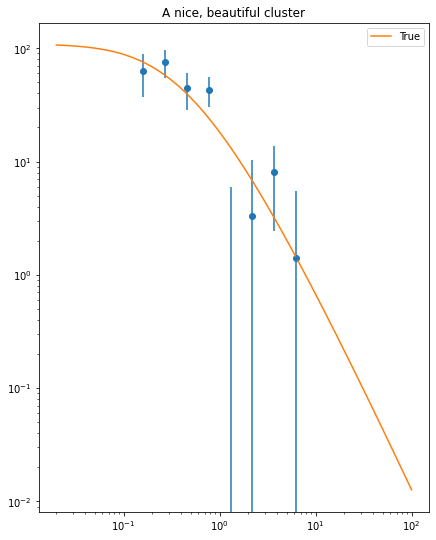

In [21]:
radii_model = np.logspace(np.log10(2e-2),2,500)
rs= xlensing.model.r_vir(Zcluster,M200true)/C200true
x = radii_model/rs
fact =  rs*xlensing.model.NFW_delta_c(C200true)*xlensing.cosmo.rhoM(Zcluster)/1e12
trueg = fact*np.array([gNFW(r) for r in x])
plt.figure(figsize=(7,9))
for stickresult in stick_results:
    plt.scatter(radii,np.array(stickresult[0]))
    plt.errorbar(radii,np.array(stickresult[0]),yerr=np.sqrt(np.diag(stickresult[1])),fmt='.')

plt.plot(radii_model,trueg,label='True')
plt.legend()

plt.xscale('log')
plt.yscale('log')
plt.title('A nice, beautiful cluster')
plt.savefig('mock.png')

## Model

Let's make a simplified version that takes only mass and concentration:

In [22]:
def NFWsimple(theta,Z,radii):
    logM200, C200  = theta
    M200 = np.power(10,logM200)
    result = xlensing.model.NFW_shear(M200, C200, Z, 1.0, 0.001, 1e10,radii)['NFW Signal'] #returns only the main shear signal - all other signals (incl cross signal) available see docstring
    return result

priors:

In [23]:
M200lo, M200hi = 13, 15
C200lo, C200hi = 0, 10

priorM200 = xlensing.fitting.ln_flat_prior_maker(M200lo, M200hi,0)
priorC200 = xlensing.fitting.ln_flat_prior_maker(C200lo, C200hi,1)
#priorPCC = xlensing.fitting.ln_gaussian_prior_maker(0.75, 0.07,2) ##Zhang et al. 2019
prior = lambda theta : priorM200(theta) + priorC200(theta)# + priorPCC(theta)

In [24]:
ndim, nwalkers, steps = 2, 256, 256
samplestick = []
#for each stack, run MCMC
burnin=round(steps/4.)
for stickresult in stick_results:

    mean_z = Zcluster

    #build data likelihood
    model = lambda theta: NFWsimple(theta,mean_z,radii)
    likelihood = xlensing.fitting.ln_gaussian_likelihood_maker((stickresult[0],stickresult[1]),model)
    posterior = lambda theta : likelihood(theta) +prior(theta)

    #initialise walkers
    pos = []
    for i in range(nwalkers):
        M200 = np.random.uniform(M200lo,M200hi)
        C200 = np.random.uniform(C200lo,C200hi)
        #PCC  = np.random.uniform(PCClo,PCChi)
        pos.append(np.array([M200,C200]))

    sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior)
    print("Running MCMC...")
    t = time.time()
    sampler.run_mcmc(pos, steps, rstate0=np.random.get_state())
    print("Done in " + str(time.time()-t) + " seconds.")
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
    samplestick.append(samples)

timestamp = time.time()
#don't mind the warnings for now

Running MCMC...
Done in 206.95198583602905 seconds.


Mvir: 1.64e+14 p 1.75e-01 m 1.85e-01
Conc: 4.54 p 2.62 m 1.64
Removed no burn in


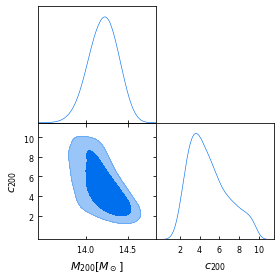

In [25]:
for samples in samplestick:
    mvir_tru,conc_tru= map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))
    print("Mvir: {:.2e}".format(10**mvir_tru[0]) + " p {:.2e}".format(mvir_tru[1]) + " m {:.2e}".format(mvir_tru[2]))
    print("Conc: {:.2f}".format(conc_tru[0]) + " p {:.2f}".format(conc_tru[1]) + " m {:.2f}".format(conc_tru[2]))
    #print("Pcc: {:.2f}".format(pcc_tru[0]) + " p {:.2f}".format(pcc_tru[1]) + " m {:.2f}".format(pcc_tru[2]))

labs =  ["M_{200} [M_\\odot]", "c_{200}"]#,"p_{cc}"]

g = plots.getSubplotPlotter()
sample = [MCSamples(samples=samples, names = labs,labels=labs) for samples in samplestick]
g.triangle_plot(sample,filled=True)
g.fig.savefig(f'posterior_test_{timestamp}.pdf',bbox_inches='tight')

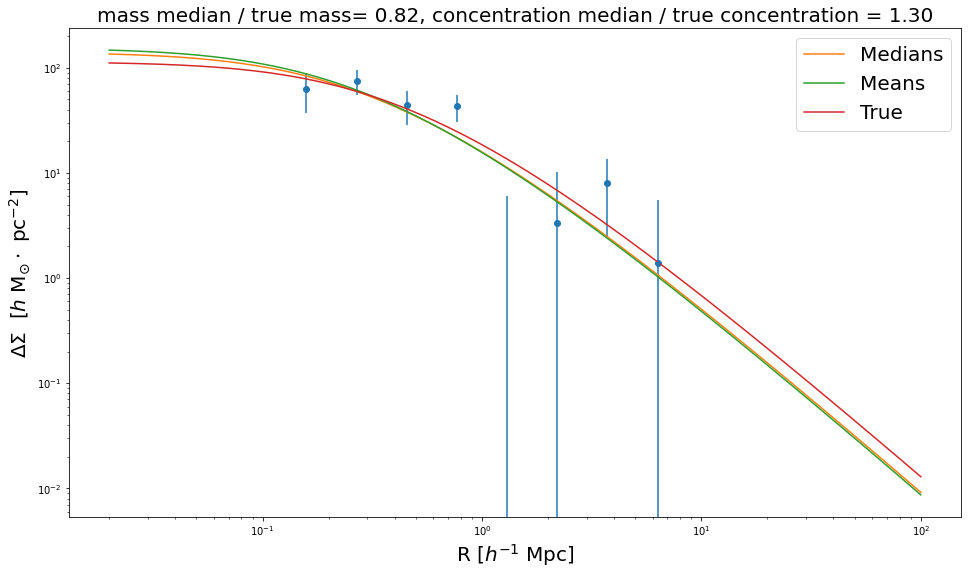

In [26]:
plt.figure(figsize=(16,9))
for stickresult in stick_results:
    plt.scatter(radii,np.array(stickresult[0]))
    plt.errorbar(radii,np.array(stickresult[0]),yerr=np.sqrt(np.diag(stickresult[1])),fmt='.')
    
    
Model = xlensing.model.NFW_shear(10**mvir_tru[0],#M200
                                  conc_tru[0],#C200
                                  0.3,#Z
                                  1,#pcc
                                  0.01,#sigma_off
                                  1e10,#M0
                                  radii=radii_model)['NFW Signal'] 
plt.plot(radii_model,Model,label='Medians')
Model = xlensing.model.NFW_shear(10**np.average(samples,axis=0)[0],#M200
                                  np.average(samples,axis=0)[1],#C200
                                  0.3,#Z
                                  1,#pcc
                                  0.01,#sigma_off
                                  1e10,#M0
                                  radii=radii_model)['NFW Signal'] 



plt.plot(radii_model,Model,label='Means')


Model = xlensing.model.NFW_shear(M200true,#M200
                                  C200true,#C200
                                  0.35,#Z
                                  1,#pcc
                                  0.01,#sigma_off
                                  1e10,#M0
                                  radii=radii_model)['NFW Signal'] 

m_ratio = 10**mvir_tru[0]/M200true

c_ratio = conc_tru[0]/C200true
plt.plot(radii_model,Model,label='True')
plt.legend(fontsize=20)
#plt.ylim(1e1,3e3)
#plt.xlim(.8e-1,2e1)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('$\Delta \Sigma$  [$h$ M$_{\odot} \cdot$ pc$^{-2}$] ',fontsize=20)
plt.xlabel('R [$h^{-1}$ Mpc]',fontsize=20)
plt.title(f'mass median / true mass= {m_ratio:.2f}, concentration median / true concentration = {c_ratio:.2f}',fontsize=20)
plt.savefig(f'fit_example_medians_means_{timestamp}.pdf',bbox_inches='tight')

## 100 fittings of the same cluster with different backgrounds

Create galaxies:

In [ ]:
M200true = 2e14
C200true = 3.5
Zcluster = 0.3
RAcluster = 0.0 #radians 
DECluster = 0.0 #radians
Ngals = 1e5
for i in tqdm.tqdm(range(100)):
  
  E1gals, E2gals, RAgals, DECgals, Zgals = gen_gal(Ngals=Ngals,Zcluster=Zcluster)


  epsilon = NFW_shear( (M200true,C200true, 0, 0, .3),(RAgals, DECgals, Zgals, E1gals, E2gals) )
  e1gals = np.real(epsilon)
  e2gals = np.imag(epsilon)

  e1err = np.array([np.abs(np.random.normal(e/100,np.abs(e/20))) for e in e1gals])
  e2err = np.array([np.abs(np.random.normal(e/100,np.abs(e/20))) for e in e2gals])
  Wgals = (0.1**2 + e1err**2 +e2err**2)/(0.1**2 + e1err**2 +e2err**2) #w=1
  Mgals = -np.random.exponential(0.03,size=int(Ngals))*0
  
  galaxy_catalog = Table([RAgals,DECgals,Zgals,e1gals,e2gals, Wgals,Mgals],names=['RA','DEC','ZPHOT','E1','E2','WEIGHT','M'])


  sr_RA = np.array(galaxy_catalog['RA'])
  sr_DEC= np.array(galaxy_catalog['DEC'])
  sr_z  = np.array(galaxy_catalog['ZPHOT'])
  sr_E1 = np.array(galaxy_catalog['E1'])
  sr_E2 = np.array(galaxy_catalog['E2'])
  sr_W = np.array(galaxy_catalog['WEIGHT'])
  sr_M = np.array(galaxy_catalog['M'])


  clusters = Table([[RAcluster],[DECluster],[Zcluster]],names=['RA','DEC', 'Z'])
  clusters['INDEX'] = np.array(range(len(clusters)))

  pool = Pool(cpu_count()) 


  #We get a partial function with a constant galaxy catalogue to iterate with clusters.
  
  survey_lensing = partial(xlensing.data.cluster_lensing,sources=(sr_RA, 
                                                                  sr_DEC, 
                                                                  sr_z, 
                                                                  sr_E1, 
                                                                  sr_E2, 
                                                                  sr_W,
                                                                  sr_M),radius=10.)

  #Make a list of clusters to get lensing data
  cl_RA=np.array(clusters['RA'])
  cl_DEC= np.array(clusters['DEC'])
  cl_z= np.array(clusters['Z'])
  cl = np.array([cl_RA,cl_DEC,cl_z]).T
  clz = zip(cl_RA,cl_DEC,cl_z)
  clzlist = [x for x in clz]

  results = pool.map(survey_lensing, clzlist)

  stick = [clusters]
  
  
  radii = np.logspace(-0.8,0.8,8)
  N = len(radii)
  bins_lims = np.logspace(np.log10(radii[0])+(np.log10(radii[0])-np.log10(radii[1]))/2,
                          np.log10(radii[N-1])-(np.log10(radii[0])-np.log10(radii[1]))/2,N+1)
  bins_lims = np.array([[bins_lims[i],bins_lims[i+1]] for i in range(N)])


  Nboot=200
  stick_results = []
  for stake in stick:
      t = time.time()
      clusterbkgs = []
      for index in stake['INDEX']:
          Sigma_crit = np.array(results[index]['Critical Density'])
          e_t = np.array(results[index]['Tangential Shear'])
          e_x = np.array(results[index]['Cross Shear'])
          W = np.array(results[index]['Weights'])
          M = np.array(results[index]['Mult. Bias'])
          R = np.array(results[index]['Radial Distance'])
          clusterbkgs.append(np.array([Sigma_crit, e_t, e_x, W, R,M]))
      print(len(clusterbkgs))
      sigmas, sigmas_cov, xigmas, xigmas_cov = stack(clusterbkgs,bins_lims,Nboot)
      stick_results.append( ( sigmas, sigmas_cov, xigmas, xigmas_cov) )
      print("Done in " + str(time.time()-t) + " seconds.")
     
  def NFWsimple(theta,Z,radii):
    logM200, C200  = theta
    M200 = np.power(10,logM200)
    result = xlensing.model.NFW_shear(M200, C200, Z, 1.0, 0.001, 1e10,radii)['NFW Signal'] #returns only the main shear signal - all other signals (incl cross signal) available see docstring
    return result

  M200lo, M200hi = 13, 15
  C200lo, C200hi = 0, 10

  priorM200 = xlensing.fitting.ln_flat_prior_maker(M200lo, M200hi,0)
  priorC200 = xlensing.fitting.ln_flat_prior_maker(C200lo, C200hi,1)
  #priorPCC = xlensing.fitting.ln_gaussian_prior_maker(0.75, 0.07,2) ##Zhang et al. 2019
  prior = lambda theta : priorM200(theta) + priorC200(theta)# + priorPCC(theta)

  ndim, nwalkers, steps = 2, 256, 256
  samplestick = []
  #for each stack, run MCMC
  burnin=round(steps/4.)
  for stickresult in stick_results:
    mean_z = Zcluster

    #build data likelihood
    model = lambda theta: NFWsimple(theta,mean_z,radii)
    likelihood = xlensing.fitting.ln_gaussian_likelihood_maker((stickresult[0],stickresult[1]),model)
    posterior = lambda theta : likelihood(theta) +prior(theta)

    #initialise walkers
    pos = []
    for i in range(nwalkers):
        M200 = np.random.uniform(M200lo,M200hi)
        C200 = np.random.uniform(C200lo,C200hi)
        #PCC  = np.random.uniform(PCClo,PCChi)
        pos.append(np.array([M200,C200]))

    sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior)
    print("Running MCMC...")
    t = time.time()
    sampler.run_mcmc(pos, steps, rstate0=np.random.get_state())
    print("Done in " + str(time.time()-t) + " seconds.")
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
    samplestick.append(samples)
  for samples in samplestick:
    mvir_tru,conc_tru= map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), 
                           zip(*np.percentile(samples, [16, 50, 84],axis=0)))
    #print("Mvir: {:.2e}".format(mvir_tru[0]) + " p {:.2e}".format(mvir_tru[1]) + " m {:.2e}".format(mvir_tru[2]))
    #print("Conc: {:.2f}".format(conc_tru[0]) + " p {:.2f}".format(conc_tru[1]) + " m {:.2f}".format(conc_tru[2]))
  
  m_ratio = 10**mvir_tru[0]/M200true
  c_ratio = conc_tru[0]/C200true
  print(m_ratio)
  print(c_ratio)
  mratio_list.append(m_ratio)
  cratio_list.append(c_ratio)
  np.save("mratio_lower_snr.npy",np.array(mratio_list))
  np.save("cratio_lower_snr.npy",np.array(cratio_list))
 

  0%|          | 0/100 [00:00<?, ?it/s]

1
Total galaxies available per bin:
[328, 542, 921, 1611, 2676, 4533, 7716, 13054]

Single cluster:
Separating galaxies per radial bin...


## 5 clusters

In [29]:
def mass_lambda_MEP(Lambda):
    Lambda0 = 40
    M0 = 2.21E14
    alpha = 1.18
    
    mass = M0*(Lambda/Lambda0)**alpha
    
    return mass

In [30]:
def c_DuttonMaccio(z, m):
    """Concentration from c(M) relation in Dutton & Maccio (2014).
    Parameters
    ----------
    z : float or array_like
        Redshift(s) of halos.
    m : float or array_like
        Mass(es) of halos (m200 definition), in units of solar masses.
    h : float, optional
        Hubble parameter. Default is from Planck13.
    Returns
    ----------
    ndarray
        Concentration values (c200) for halos.
    References
    ----------
    Calculation from Planck-based results of simulations presented in:
    A.A. Dutton & A.V. Maccio, "Cold dark matter haloes in the Planck era:
    evolution of structural parameters for Einasto and NFW profiles,"
    Monthly Notices of the Royal Astronomical Society, Volume 441, Issue 4,
    p.3359-3374, 2014.
    """


    a = 0.52 + 0.385 * np.exp(-0.617 * (z**1.21))  # EQ 10
    b = -0.101 + 0.026 * z                         # EQ 11

    logc200 = a + b * np.log10(m * 1 / (10.**12))  # EQ 7

    concentration = 10.**logc200

    return concentration

In [31]:
c_DuttonMaccio(.3,4e14)

4.0826185353213065

In [32]:
clusters_z = [0.3, 0.2, 0.35, 0.4, 0.5]
clusters_M = [2, 1, 3, 4, 2 ] #1e14
clusters_C = [c_DuttonMaccio(z, m*1e14)+np.random.normal(0,c_DuttonMaccio(z, m*1e14)/20) 
              for z,m in zip(clusters_z,clusters_M)]

In [33]:
clusters_C

[4.174565458790403,
 4.99225477425597,
 4.166080435010702,
 3.9063234881443605,
 4.397500242468726]

In [34]:
Ngals = 1e5

E1gals, E2gals, RAgals, DECgals, Zgals = gen_gal(Ngals=Ngals)

In [35]:
M200lo, M200hi = 13, 15
C200lo, C200hi = 0, 10
priorM200 = xlensing.fitting.ln_flat_prior_maker(M200lo, M200hi,0)
priorC200 = xlensing.fitting.ln_flat_prior_maker(C200lo, C200hi,1)

In [36]:
model = lambda theta: NFWsimple(theta,mean_z,radii)
likelihood = xlensing.fitting.ln_gaussian_likelihood_maker((stickresult[0],stickresult[1]),model)
posterior = lambda theta : likelihood(theta) +prior(theta)
